In [1]:
import sys
sys.path.append("..")
import os

from dacludek.model import DaCluDeK

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

# Assignment confidence

In [2]:
def get_most_similar_keywords_by_class(n: int, documents_df: pd.DataFrame, labels_df: pd.DataFrame, load_cache: bool = True):
    """ Get most similar keywords by class 
    
    Args:
        n (int): number of keywords to return
        documents_df (pd.DataFrame): documents dataframe
        labels_df (pd.DataFrame): labels dataframe
        load_cache (bool): load cache or not

    Returns:
        keywords_by_class (dict): keywords by class
    """
    keywords_by_class = {}

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    documents_repr = ''.join([item[0] for item in train_docs])[:10]

    if not load_cache:
        defined_keywords = {}
        for _, row in labels_df.iterrows():
            defined_keywords[row['class_name']] = row['class_keywords'].split(' ')

        inner_doc2vec_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=train_docs, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, doc2vec_n_spacy_keywords=20)
        inner_doc2vec_model.load_embeddings_model()

    keywords_df = pd.read_csv(f'../dacludek/cache/{documents_repr}_spacy_keywords.csv')
    
    for class_name in keywords_df['class_name'].unique():
        keywords_by_class[class_name] = keywords_df[keywords_df['class_name'] == class_name]['class_result_keywords'].apply(lambda x: x[1:-1].replace('\'', '').split(', ')).tolist()[0][:n]
    return keywords_by_class

In [3]:
def get_doc2vec_assignment_confidence_df(dataset_name: str):
    """ Get assignment confidence dataframe for Doc2Vec model

    Args:
        dataset_name (str): dataset name

    Returns:
        result_df (pd.DataFrame): result dataframe with columns: document, dataset_type, y_true, y_pred, confidence
    """
    documents_df = pd.read_csv(f'../../datasets/data/{dataset_name}/documents.csv')
    labels_df = pd.read_csv(f'../../datasets/data/{dataset_name}/labels.csv')

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    test_docs = documents_df[documents_df['dataset_type'] == 'test']['document'].tolist()

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    documents_repr = ''.join([item[0] for item in train_docs])[:10]

    load_cache = os.path.exists(f'../dacludek/cache/{documents_repr}_spacy_keywords.csv')
    print(f'Loading cache: {load_cache}')

    keywords_by_class = get_most_similar_keywords_by_class(10, documents_df, labels_df, load_cache=load_cache)

    # -- Doc2Vec
    doc2vec_model = DaCluDeK(defined_keywords=keywords_by_class, train_documents=train_docs, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20)
    doc2vec_model.fit()

    y_pred_train = doc2vec_model.predict(train_docs)
    y_pred_test = doc2vec_model.predict(test_docs)

    result_df = pd.DataFrame(columns=['document', 'dataset_type', 'y_true', 'y_pred', 'confidence'])
    result_df['document'] = documents_df['document']
    result_df['dataset_type'] = documents_df['dataset_type']
    result_df['y_true'] = documents_df['class_name']
    result_df['y_pred'] = y_pred_train['class_name'].tolist() + y_pred_test['class_name'].tolist()
    result_df['confidence'] = y_pred_train['similarity_score'].tolist() + y_pred_test['similarity_score'].tolist()
    return result_df

In [4]:
def get_transformer_assignment_confidence_df(dataset_name: str):
    """ Get assignment confidence dataframe for Transformer model

    Args:
        dataset_name (str): dataset name

    Returns:
        result_df (pd.DataFrame): result dataframe with columns: document, dataset_type, y_true, y_pred, confidence
    """
    documents_df = pd.read_csv(f'../../datasets/data/{dataset_name}/documents.csv')
    labels_df = pd.read_csv(f'../../datasets/data/{dataset_name}/labels.csv')

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    test_docs = documents_df[documents_df['dataset_type'] == 'test']['document'].tolist()

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    documents_repr = ''.join([item[0] for item in train_docs])[:10]

    load_cache = os.path.exists(f'../dacludek/cache/{documents_repr}_spacy_keywords.csv')
    print(f'Loading cache: {load_cache}')

    keywords_by_class = get_most_similar_keywords_by_class(10, documents_df, labels_df, load_cache=load_cache)

    # -- SentenceTransformer
    sentence_transformer_model = DaCluDeK(defined_keywords=keywords_by_class, train_documents=train_docs, embedding_model_name='SentenceTransformer', verbose=True)
    sentence_transformer_model.fit()

    y_pred_train = sentence_transformer_model.predict(train_docs)
    y_pred_test = sentence_transformer_model.predict(test_docs)
    
    result_df = pd.DataFrame(columns=['document', 'dataset_type', 'y_true', 'y_pred', 'confidence'])
    result_df['document'] = documents_df['document']
    result_df['dataset_type'] = documents_df['dataset_type']
    result_df['y_true'] = documents_df['class_name']
    result_df['y_pred'] = y_pred_train['class_name'].tolist() + y_pred_test['class_name'].tolist()
    result_df['confidence'] = y_pred_train['similarity_score'].tolist() + y_pred_test['similarity_score'].tolist()
    return result_df

In [5]:
doc2vec_confidence_df = get_doc2vec_assignment_confidence_df('BBC_News')
doc2vec_confidence_df.head()

Loading cache: True


/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,document,dataset_type,y_true,y_pred,confidence
0,hit shelf combine medium player phone gaming g...,train,tech,business,0.538758
1,bid hope join host apply host tournament aim r...,train,sport,business,0.589930
2,lord wrong detainee straw straw attack decisio...,train,politics,politics,0.562537
3,leak answer minister explain budget detail pri...,train,politics,politics,0.525618
4,delight manager pay tribute goal striker beat ...,train,sport,business,0.500956


In [6]:
transformer_confidence_df = get_transformer_assignment_confidence_df('BBC_News')
transformer_confidence_df.head()

Loading cache: True


,document,dataset_type,y_true,y_pred,confidence
0,hit shelf combine medium player phone gaming g...,train,tech,entertainment,0.767273
1,bid hope join host apply host tournament aim r...,train,sport,sport,0.743376
2,lord wrong detainee straw straw attack decisio...,train,politics,politics,0.718422
3,leak answer minister explain budget detail pri...,train,politics,politics,0.779342
4,delight manager pay tribute goal striker beat ...,train,sport,sport,0.758381


In [7]:
def plot_confidence(doc2vec_confidence_df: pd.DataFrame, transformer_confidence_df: pd.DataFrame, title: str):
    """ Plot confidence histogram for Doc2Vec and SentenceTransformer models

    Args:
        doc2vec_confidence_df (pd.DataFrame): Doc2Vec confidence dataframe
        transformer_confidence_df (pd.DataFrame): SentenceTransformer confidence dataframe
        title (str): plot title
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title, fontweight='bold', fontsize=16)

    doc2vec_confidence_df_copy = doc2vec_confidence_df.rename(columns={'dataset_type': 'Dataset type'}).copy()
    sns.histplot(data=doc2vec_confidence_df_copy, x='confidence', hue='Dataset type', ax=ax[0], bins=20, kde=True)
    ax[0].set_title('Doc2Vec', fontweight='bold', fontsize=14)

    transformer_confidence_df_copy = transformer_confidence_df.rename(columns={'dataset_type': 'Dataset type'}).copy()
    sns.histplot(data=transformer_confidence_df_copy, x='confidence', hue='Dataset type', ax=ax[1], bins=20, kde=True)
    ax[1].set_title('SentenceTransformer', fontweight='bold', fontsize=14)

    fig.tight_layout()
    fig.savefig(f'../../figures/dacludek/{title.lower().replace(" ", "_").replace("(", "").replace(")", "")}.png', dpi=300)

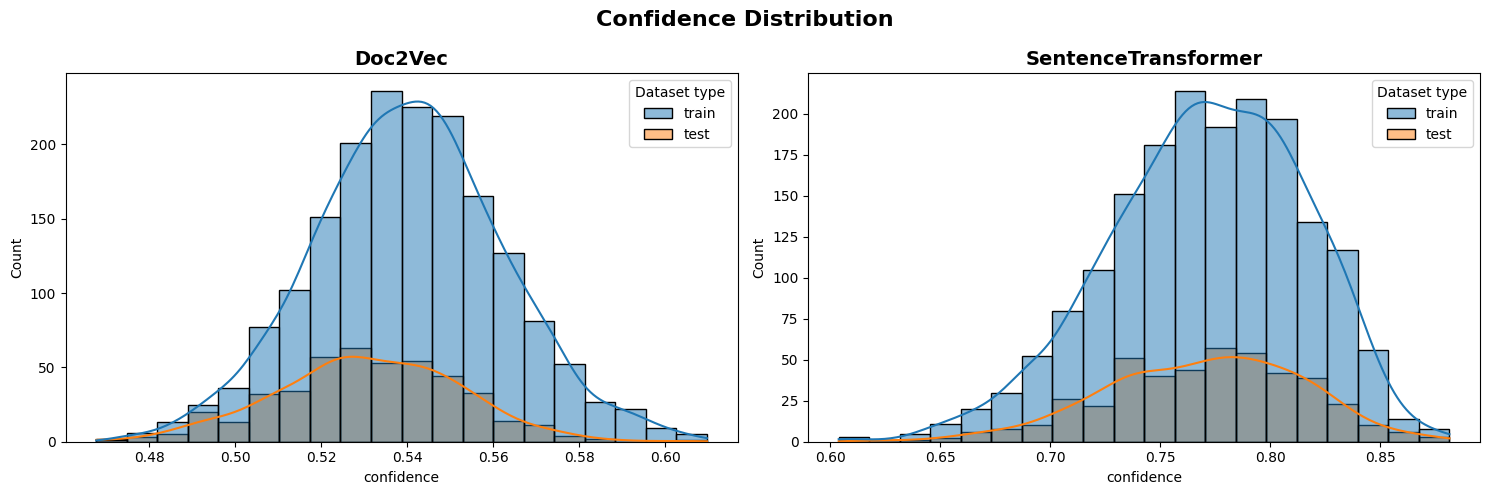

In [8]:
plot_confidence(doc2vec_confidence_df, transformer_confidence_df, 'Confidence Distribution')

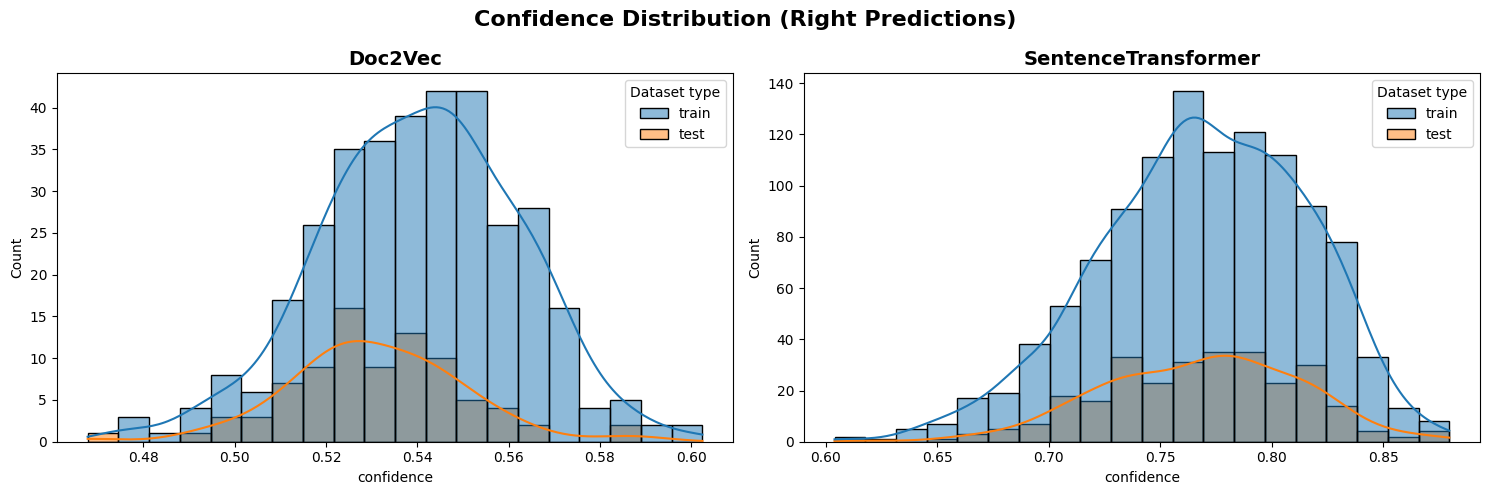

In [9]:
doc2vec_right_confidence_df = doc2vec_confidence_df[doc2vec_confidence_df['y_true'] == doc2vec_confidence_df['y_pred']]
transformer_right_confidence_df = transformer_confidence_df[transformer_confidence_df['y_true'] == transformer_confidence_df['y_pred']]

plot_confidence(doc2vec_right_confidence_df, transformer_right_confidence_df, 'Confidence Distribution (Right Predictions)')

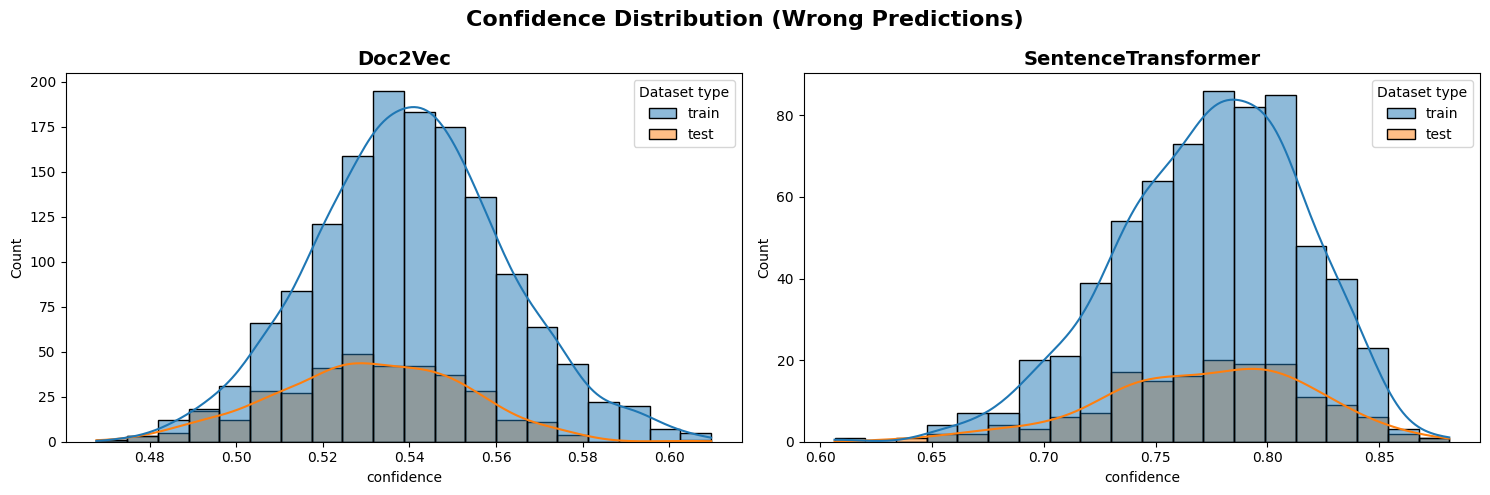

In [10]:
doc2vec_wrong_confidence_df = doc2vec_confidence_df[doc2vec_confidence_df['y_true'] != doc2vec_confidence_df['y_pred']]
transformer_wrong_confidence_df = transformer_confidence_df[transformer_confidence_df['y_true'] != transformer_confidence_df['y_pred']]

plot_confidence(doc2vec_wrong_confidence_df, transformer_wrong_confidence_df, 'Confidence Distribution (Wrong Predictions)')

In [11]:
datasets_confidence_dfs = {}

for dataset in ['BBC_News', '20NewsGroup', 'DBLP', 'M10']:
    transformer_confidence_df_on_dataset = get_transformer_assignment_confidence_df(dataset)
    datasets_confidence_dfs[dataset] = transformer_confidence_df_on_dataset

Loading cache: True
Loading cache: Truedocuments...                                                                         
Loading cache: Truedocuments...                                                                                    
Loading cache: Truedocuments...                                                             


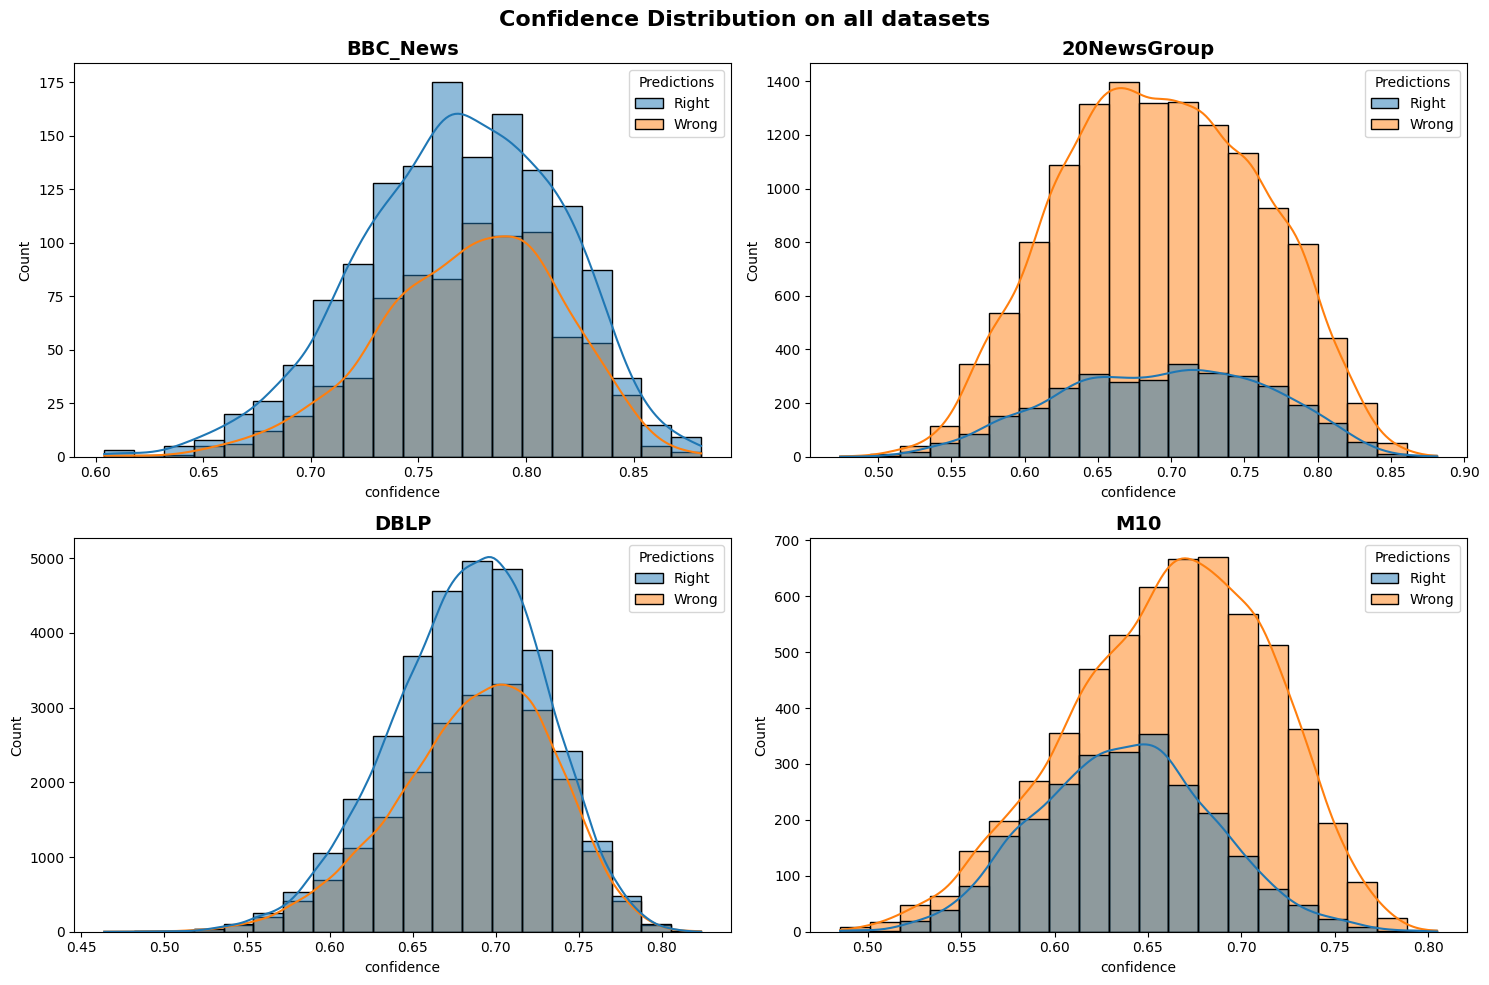

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Confidence Distribution on all datasets', fontweight='bold', fontsize=16)

x, y = 0, 0

for key in datasets_confidence_dfs.keys():
    confidence_df = datasets_confidence_dfs[key]
    confidence_df['Predictions'] = confidence_df['y_true'] == confidence_df['y_pred']
    confidence_df['Predictions'] = confidence_df['Predictions'].apply(lambda x: 'Right' if x else 'Wrong')
    confidence_df = confidence_df.sort_values(by='Predictions')

    sns.histplot(data=confidence_df, x='confidence', hue='Predictions', ax=ax[x][y], bins=20, kde=True)
    ax[x][y].set_title(key, fontweight='bold', fontsize=14)

    y += 1
    if y == 2:
        x += 1
        y = 0

fig.tight_layout()
fig.savefig(f'../../figures/dacludek/confidence_distribution_on_all_datasets.png', dpi=300)